# Natural Spline Interpolation
---
*Numerical Methods - homework 1,
Matic Šutar, ms4861@student.uni-lj.si*

## Problem definition

Let $(x_i, f_i)_i, i\in\{1,2,\dots,n\}$ be the set of interpolation points.

A natural cubic spline $S$ is then a function with the following properties:
1. $S(x_i) = f_i$, for $i\in\{1,2,\dots,n\}$
2. $S$ is a polynom with max degree of 3 on each subinterval $[x_i, x_{i+1}]$ 
3. $S$ is twice continuously diferentiable on the interval $[x_1, x_n]$
4. $S''(x_1)=S''(x_n)=0$ (natural)

On each subinterval $[x_i, x_{i+1}]$, $S$ is defined as:

$S(x)=S_i(x)=a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3.$

Our task is to find the parameters $a_i, b_i, c_i, d_i$ where $i\in\{1,2,\dots,n-1\}$ for the given interpolation points.

## Writing a system of linear equations

### The direct method

Let's first compute the first and second order derivatives of $S_i$:

$S_i(x)=a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3$

$S_i'(x)=b_i + 2c_i(x - x_i) + 3d_i(x - x_i)^2$

$S_i''(x)=2c_i + 6d_i(x - x_i)$

From the 1. and 2. property of S we get the following set of equations:

Let $h = x_{i+1}-x_i$

$S_i(x_i)=a_i=f_i$

$s_i(x_{i+1})=a_i + b_ih + c_ih^2 + d_ih^3=f_{i+1} \to b_ih + c_ih^2 + d_ih^3 = f_{i+1}-f_{i}$

where $i\in\{1,2,\dots, n-1\}$

From the 2. and 3. property of S we get:

$S_i'(x_{i+1})=S_{i+1}'(x_{i+1}) \to b_i - b_{i+1} + 2c_ih + 3d_ih^2 = 0$

$S_i''(x_{i+1})=S_{i+1}''(x_{i+1}) \to 2c_i - 2c_{i+1} + 6d_ih = 0$

where $i\in\{1,2,\dots, n-2\}$

The last 2 equations come from the 4. property:

$S_1''(x_1)=0 \to c_1 = 0$

$S_{n-1}''(x_n)=0 \to 2c_i + 6d_ih = 0$

This way we get a set of $4(n-1)$ linear equations and $4(n-1)$ parameters.

### Using a tridiagonal system

The coeficients $b_i, c_i, d_i$ can be expresed using second derivatives. There is a tridiagonal system that can be written for the second derivatives. The derivation of this method will not be presented, however the method is implemented as a static method **interpolate2**.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Spline:
    """
    A natural cubic spline interpolant.

    Inputs:
    coef: list of coefficients of the spline

    A natural cubic spline S satisfies:
    1. S(x_i) = f_i
    2. S is a polynomial of degree max 3 on [x_i, x_{i+1}]
    3. S is twice continuously differentiable on [x_0, x_n]
    4. S''(x_0) = S''(x_n) = 0
    """
    def __init__(self, x, y, direct=True):
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        self.knots = x
        if direct:
            self.coefs = self.interpolate(x, y)
        else:
            self.coefs = self.interpolate2(x, y)
            

    @staticmethod
    def interpolate(x, y):
        """
        Computes the coefficients of the natural cubic spline interpolant.
        points must be sorted in increasing order of x.

        Returns a matrix of coefficients of the spline,
        where the i-th row contains the coefficients of the i-th spline.
        """
        n = len(x)
        A = np.zeros((3*(n-1), 3*(n-1)))
        b = np.zeros(3*(n-1))
        
        h = np.diff(x)

        # S is continuos
        for i in range(n-1):
            A[i, 3*i:3*(i+1)] = [h[i], h[i]**2, h[i]**3]
            b[i] = y[i+1]-y[i]
        
        # S' is continuos
        for i in range(n-2):
            A[n-1+i, 3*i:3*(i+1)+1] = [1, 2*h[i], 3*h[i]**2, -1]
        
        # S'' is continuos
        for i in range(n-2):
            A[2*n-3+i, 3*i:3*(i+1)+2] = [0, 2, 6*h[i], 0, -2]

        # S''(x_0) = S''(x_n) = 0
        A[-2, 1] = 1
        A[-1, -2:] = [2, 6*h[-1]]
        
        # solve the system
        coefs = np.linalg.solve(A, b)
        coefs = coefs.reshape((n-1, 3))
        coefs = np.concatenate((y[:-1].reshape(-1, 1), coefs), axis=1)
        return coefs

    @staticmethod
    def interpolate2(x, y):
        n = len(x)-1
        a = y
        b = np.zeros(n)
        d = np.zeros(n)
        h = np.diff(x)
        alpha = np.zeros(n)
        alpha[1:] = 3/h[1:] * (a[2:] - a[1:-1]) - 3/h[:-1] * (a[1:-1] - a[:-2])
        c = np.zeros(n+1)
        l = np.zeros(n+1)
        mu = np.zeros(n+1)
        z = np.zeros(n+1)
        l[0] = 1
        mu[0] = 0
        z[0] = 0
        for i in range(1, n):
            l[i] = 2*(x[i+1] - x[i-1]) - h[i-1]*mu[i-1]
            mu[i] = h[i]/l[i]
            z[i] = (alpha[i] - h[i-1]*z[i-1])/l[i]
        l[n] = 1
        z[n] = 0
        c[n] = 0
        for j in range(n-1, -1, -1):
            c[j] = z[j] - mu[j]*c[j+1]
            b[j] = (a[j+1] - a[j])/h[j] - h[j]*(c[j+1] + 2*c[j])/3
            d[j] = (c[j+1] - c[j])/(3*h[j])
        coefs = np.empty((n, 4))
        coefs[:, 0] = a[:-1]
        coefs[:, 1] = b
        coefs[:, 2] = c[:-1]
        coefs[:, 3] = d
        return coefs

    def value(self, x):
        """
        Evaluates the natural cubic spline interpolant at x.
        """
        # check if x is in the domain
        if x < self.knots[0] or x > self.knots[-1]:
            raise ValueError("x is out of the domain of the spline")
        # find the interval
        idx = 0
        while self.knots[idx] < x:
            idx += idx+1
        idx -= 1
        # evaluate the spline
        coef = self.coefs[idx]
        diff = x - self.knots[idx]
        return coef[0] + coef[1]*diff + coef[2]*diff**2 + coef[3]*diff**3


    def plot(self):
        """
        Plots the natural cubic spline interpolant. The colors of the splines alternate between red and blue.
        """
        x = self.knots
        for i in range(len(x)-1):
            coef = self.coefs[i]
            x_vals = np.linspace(x[i], x[i+1], 100)
            y_vals = coef[0] + coef[1]*(x_vals-x[i]) + coef[2]*(x_vals-x[i])**2 + coef[3]*(x_vals-x[i])**3
            plt.plot(x_vals, y_vals, color='red' if i%2 == 0 else 'blue')
        plt.show()

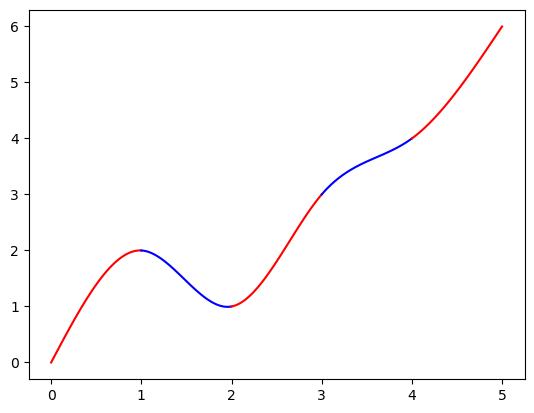

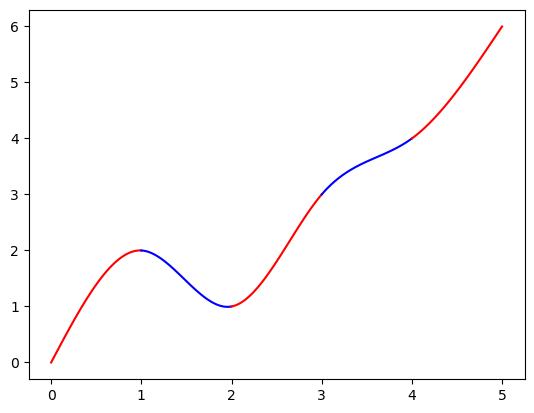

In [4]:
x = np.array([0,1,2,3,4,5])
y = np.array([0,2,1,3,4,6])
S = Spline(x, y)
S_fast = Spline(x, y, direct=False)
S.plot()
S_fast.plot()

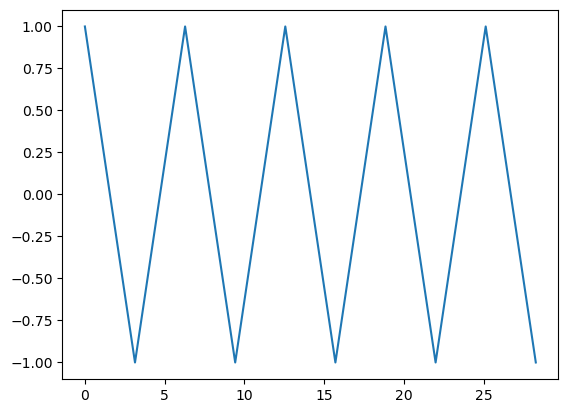

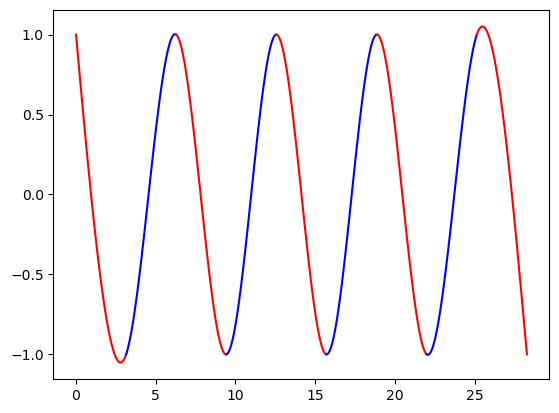

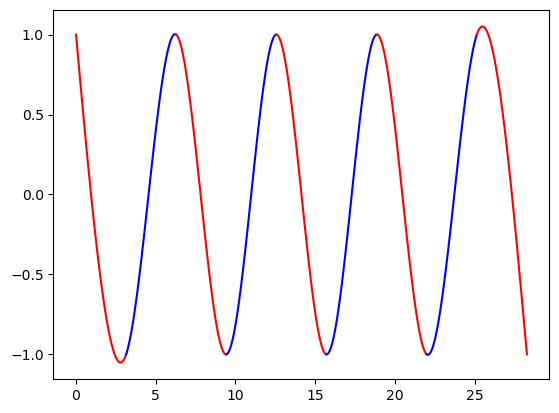

In [5]:
x = np.arange(10)*np.pi
y = np.cos(x)
plt.plot(x, y)
plt.show()
S = Spline(x, y)
S_fast = Spline(x, y, direct=False)
S.plot()
S_fast.plot()